In [18]:
from adc import align, count, fit
from functools import partial
from importlib.metadata import version
import urllib3
import shutil
import os
import pathlib


import matplotlib.pyplot as plt
import yaml

import tifffile as tf
import seaborn as sns

In [2]:
__version__ = version('anchor-droplet-chip')
__version__

'0.0.3.dev0+g7d4f7cc.d20220628'

In [3]:
def load_data(url, filename, dir=None):
    if dir is not None:
        cwd = pathlib.Path.cwd()
        subfolder = cwd.joinpath(dir)
        subfolder.mkdir(exist_ok=True)
        filename = subfolder.joinpath(filename)
    else:
        filename = pathlib.Path(filename)
        
    if not filename.exists():
        print(f'loading {filename}')
        c = urllib3.PoolManager()

        with c.request('GET',url, preload_content=False) as resp, filename.open(mode='wb') as out_file:
            shutil.copyfileobj(resp, out_file)

        resp.release_conn()
    else:
        print(f'{filename} already exists')
    print(f'reading from disk {filename}')
    return tf.imread(filename)


def process_urls(key, config):
    if 'url' in config[key]:
        return load_data(**config[key])
    else:
        return config[key]

def load_dataset(path):
    with open(path,'r') as f:
        config  = yaml.load(f, Loader=yaml.SafeLoader)
        print (config)

    return {key: process_urls(key, config) for key in config}
     

In [4]:
data_0h = load_dataset('test_data_0h.yaml')
data_24h = load_dataset('test_data_24h.yaml')


{'data': {'filename': '00ng_BF_TRITC_bin2.tif', 'dir': 'day1', 'url': 'https://github.com/BaroudLab/anchor-droplet-chip/releases/download/v0.0.1/00ng_BF_TRITC_bin2.tif'}, 'mask2': {'filename': 'labels_bin2.tif', 'url': 'https://github.com/BaroudLab/anchor-droplet-chip/releases/download/v0.0.1/labels_bin2+100.tif'}, 'template16': {'filename': 'template_bin16_bf.tif', 'url': 'https://github.com/BaroudLab/anchor-droplet-chip/releases/download/v0.0.1/template_bin16_bf.tif'}, 'path_to_save': 'day1/00ng_aligned.tif', 'binnings': [2, 16, 2], 'constraints': {'scale': [1, 0.2], 'tx': [0, 500], 'ty': [0, 50], 'angle': [0, 30]}}
/home/aaristov/Documents/anchor-droplet-chip/day1/00ng_BF_TRITC_bin2.tif already exists
reading from disk /home/aaristov/Documents/anchor-droplet-chip/day1/00ng_BF_TRITC_bin2.tif
labels_bin2.tif already exists
reading from disk labels_bin2.tif
template_bin16_bf.tif already exists
reading from disk template_bin16_bf.tif
{'data': {'filename': '00ng_BF_TRITC_bin2-24h.tif', '

In [5]:
aligned_stack_0h, tvec_0h = align.align_stack(**data_0h)
aligned_stack_24h, tvec_0h = align.align_stack(**data_24h)


2022-07-05 18:23:55,327 INFO : Found transform: {'tvec': array([-66.49074166, -48.11976624]), 'success': 0.033438634530226136, 'angle': -1.7821884214446868, 'scale': 0.9967281194497374, 'Dscale': 0.00048304883928820217, 'Dangle': 0.013485166317051244, 'Dt': 0.25, 'timg': None}
2022-07-05 18:23:55,328 INFO : Applying the transform to the brightfield channel
2022-07-05 18:24:16,247 INFO : Applying the transform to the fluorescence channel
2022-07-05 18:24:48,881 INFO : Found transform: {'tvec': array([-130.05149521, -289.98512969]), 'success': 0.02192667678082884, 'angle': -1.6569281453164137, 'scale': 0.9972586375438617, 'Dscale': 0.0004754544406975486, 'Dangle': 0.013477088948787063, 'Dt': 0.25, 'timg': None}
2022-07-05 18:24:48,881 INFO : Applying the transform to the brightfield channel
2022-07-05 18:25:07,262 INFO : Applying the transform to the fluorescence channel


In [13]:
tf.imwrite('day1/00ng_BF_TRITC_bin2-aligned.tif', aligned_stack_0h, imagej=True, metadata=align.META_ALIGNED)
tf.imwrite('day2/00ng_BF_TRITC_bin2-24h-aligned.tif', aligned_stack_24h, imagej=True, metadata=align.META_ALIGNED)


In [7]:
counts_0h = count.stack(aligned_stack_0h)
counts_0h

,label,x,y,n_cells
0,1,417.128241,663.248626,2
1,2,948.961450,664.647675,3
2,3,1475.729516,665.043884,3
3,4,16298.040220,661.226322,2
4,5,16826.050217,660.757642,1
...,...,...,...,...
496,497,4646.000000,5962.000000,2
497,498,5177.702880,5961.897296,4
498,499,5706.998255,5961.526499,0
499,500,6236.971642,5961.537016,0


2022-07-05 18:28:41,494 INFO : Max value: 42, truncating to 8 based on mean + 3 * std


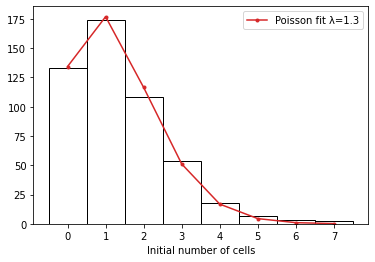

In [11]:
poisson_lambda = fit.poisson(counts_0h.n_cells)   

In [8]:
counts_24h = count.stack(aligned_stack_24h)
counts_24h

,label,x,y,n_cells
0,1,417.128241,663.248626,17
1,2,948.961450,664.647675,78
2,3,1475.729516,665.043884,91
3,4,16298.040220,661.226322,64
4,5,16826.050217,660.757642,22
...,...,...,...,...
496,497,4646.000000,5962.000000,21
497,498,5177.702880,5961.897296,28
498,499,5706.998255,5961.526499,0
499,500,6236.971642,5961.537016,0


In [15]:
table = counts_0h.copy()

In [16]:
table.loc[:, "n_cells_final"]  = counts_24h.n_cells

/home/aaristov/Documents/anchor-droplet-chip/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 82.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aaristov/Documents/anchor-droplet-chip/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 38.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aaristov/Documents/anchor-droplet-chip/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 23.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='n_cells', ylabel='n_cells_final'>

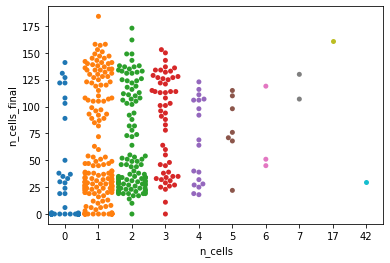

In [19]:
sns.swarmplot(data=table, x='n_cells', y='n_cells_final')